# Grafos de fluxos

Na sua versão mais simples, um *grafo de fluxos* é um grafo orientado onde cada aresta modela uma "conduta" onde pode fluir "alguma coisa" (gás, água, trânsito automóvel, etc) sujeita a uma capacidade máxima. Mais em informação em https://en.wikipedia.org/wiki/Flow_network.

Usando o `networkx` podemos modelar um grafo de fluxos usando um `DiGraph` (*directed graph*), usando atributos adicionais para representar a capacidade máxima de cada arco e o respectivo fluxo efectivo. Por exemplo, o seguinte código cria um grafo de fluxos com 6 nodos e 10 arcos.

In [2]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edge(0,1,capacity=16)
#graph.add_edge(0,1,flow=9,capacity=16)
graph.add_edge(0,2,capacity=13)
graph.add_edge(1,2,capacity=10)
graph.add_edge(1,3,capacity=12)
graph.add_edge(2,1,capacity=4)
graph.add_edge(2,4,capacity=14)
graph.add_edge(3,2,capacity=9)
graph.add_edge(3,5,capacity=20)
graph.add_edge(4,3,capacity=7)
graph.add_edge(4,5,capacity=4)

Podemos desenhar este grafo de fluxos usando a seguinte função que assume que o grafo é planar e que coloca como fluxo efectivo o caracter `?` caso este atributo não esteja definido.

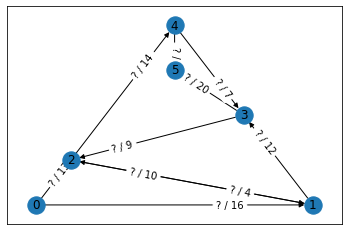

In [3]:
def draw_flow_network(graph):
    pos = nx.planar_layout(graph)
    labels = {}
    for (o,d) in graph.edges():
        if 'flow' in graph[o][d]:
            labels[(o,d)] = str(graph[o][d]['flow']) + ' / ' + str(graph[o][d]['capacity'])
        else:
            labels[(o,d)] = '? / ' + str(graph[o][d]['capacity'])                        
    nx.draw_networkx(graph,pos)
    nx.draw_networkx_edge_labels(graph,pos,labels,label_pos=0.3)


draw_flow_network(graph)

## Max-flow

Um dos problemas clássicos com grafos de fluxos consiste em determinar qual o fluxo máximo que pode existir entre dois nodos concretos do grafo.

Usando programação inteira mista (com variáveis inteiras e reais) podemos determinar este fluxo máximo da seguinte forma.

Mais uma vez usaremos a biblioteca [OR-Tools](https://developers.google.com/optimization) para fazer a interface para o SCIP. Esta biblioteca pode ser instalada com o commando `pip install ortools`.

In [4]:
!pip install ortools

### Análise do problema

Dado um grafo orientado $(V,E)$, uma capacidade $C_e \ge 0$ para cada arco $e \in E$, um nodo $s$ correspondente à origem e um nodo $t$ correspondente ao destino, precisamos de uma variável $f_e$ do tipo real por cada arco $e \in E$, que irá representar o fluxo efectivo nesse arco. Para encontrar o fluxo máximo entre $s$ e $t$ basta maximizar

$$
\sum_{(s,v) \in E} f_{(s,v)} - \sum_{(v,s) \in E} f_{(v,s)}
$$

ou seja, a soma do fluxos efectivos com origem em $s$ (alternativamente, poderia-se maximizar a soma dos fluxos efectivos com destino $t$), sujeito às seguintes restrições:
- A capacidade de cada arco é respeitada
- O fluxo que sai de cada nodo é igual ao que entra (exceptuando em $s$ e $t$)

Notasss: \
Quero enviar coisas de s (source) para t (target) \
f representa o fluxo 

### Exercício 1

Formalize estas restrições.

A capacidade de cada arco é respeitada

$ \forall_{e \in E} f_e <= C_e $

O fluxo que sai de cada nodo é igual ao que entra (exceptuando em $s$ e $t$)

$ \forall_{v \in V \{s,t} \sum_{(x,v) \in E} f_{(x,v)} = \sum_{(v,x) \in E} f_{(v,x)} $

### Exercício 2

Implemente a função `max_flow` que dado um grafo de fluxos, determina o fluxo máximo entre `s` e `t`, definindo também o atributo `flow` com o fluxo efectivo de cada arco necessário para atingir esse fluxo máximo. Em `networkx` pode usar o método `edges` para aceder aos arcos de um grafo, e os métodos `in_edges` e `out_edges` para aceder aos arcos de entrada e saída de um determinado vértice.

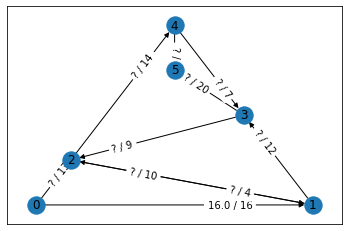

In [25]:
from ortools.linear_solver import pywraplp

def max_flow(graph,s,t):
    sol = pywraplp.Solver.CreateSolver('SCIP')
    # completar

    f = {}

    for e in graph.edges():
      (a,b) = e
      f[e] = sol.NumVar(0,graph[a][b]['capacity'], str(e))

    for v in graph.nodes:
      if v != s and v!= t:
        sol.Add(sum(f[e] for e in graph.in_edges(v)) == sum(f[e] for e in graph.out_edges(v)))

    sol.Maximize(sum(f[e] for e in graph.out_edges(s)) - sum(f[e] for e in graph.in_edges(s)))

    assert (sol.Solve() == pywraplp.Solver.OPTIMAL)

    for e in graph.edges():
      (a,b) = e
      graph[a][b]['flow'] = f[a,b].solution_value()
      return sol.Objective().Value()


assert max_flow(graph,0,5) == 23
draw_flow_network(graph) 
      

## Min-cut

Um dos resultados fundamentais sobre grafos de fluxos, conforme https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem, diz que o fluxo máximo entre dois vértices é igual à soma da capacidade dos arcos que estabelecem um *corte mínimo* entre esses vértices. Num grafo um *corte mínimo* é um conjunto de arcos que divide os nodos em dois conjuntos disjuntos satisfazendo algum critério de minimalidade. Neste caso estamos interessados em dividir o grafo em dois conjuntos $S$ e $T$ onde a origem $s \in S$ e o destino $t \in T$, minimizando a capacidade total dos arcos que pertecem ao corte, ou seja, a capacidade total dos arcos que ligam $S$ a $T$.

### Análise do problema

Dado um grafo orientado $(V,E)$, uma capacidade $C_e \ge 0$ para cada arco $e \in E$, um nodo $s$ correspondente à origem e um nodo $t$ correspondente ao destino, precisamos de uma variável binária $d_{(a,b)}$ por cada aresta $(a,b) \in E$, que terá o valor 1 se a respectiva aresta pertencer ao corte entre $S$ e $T$ (ou seja, se $a \in S$ e $b \in T$), e de uma variável binária $x_v$ por cada vértice $v \in V$, que terá o valor 1 se o respectivo vértice pertencer a $S$ (se o valor for 0 é porque $v \in T$). Para encontrar o corte mínimo basta minimizar

$$
\sum_{e \in E} d_{e} \cdot C_e
$$

sujeito às seguintes restrições:
- O nodo $s$ pertence a $S$ e o nodo $t$ pertence a $T$
- Uma aresta com origem em $S$ e destino em $T$ pertence ao corte

### Exercício 3

Formalize estas restrições.


$ d_{(a,b)} \le x_a $

$ d_{(a,b)} \le 1-x_b $

$ x_a + (1-x_b) \le d_{(a,b)} +1 $

$ x_a + x_b \le d_{(a,b)}$

### Exercício 4

Implemente a função `min_cut` que dado um grafo de fluxos determina o fluxo máximo entre `s` e `t`.

In [32]:
def min_cut(graph,s,t):
    sol = pywraplp.Solver.CreateSolver('SCIP')
    # completar
    x={}
    for v in graph.nodes(): 
        x[v] = sol.BoolVar(str(v))
    d = {}
    for e in graph.edges(): 
        d[e] = sol.BoolVar(str(e))
    sol.Add(x[s] == 1)
    sol.Add(x[t] == 0)
    for (a,b) in graph.edges(): 
        sol.Add(d[a,b]<=x[a])
        sol.Add(d[a,b]<=1-x[b])
        sol.Add(x[a]-x[b]<=d[a,b])
    sol.Minimize(sum(d[a,b] * graph[a][b]['capacity'] for (a,b) in graph.edges()))
    assert(sol.Solve() == pywraplp.Solver.OPTIMAL)
    print([e for e in graph.edges() if round(d[e].solution_value()) ==1])
    return (sol.Objective().Value())

assert min_cut(graph,0,5) == 23

[(1, 3), (4, 3), (4, 5)]


## Outros problemas de corte mínimo

Outro problema relacionado com o corte mínimo consiste em determinar, para um grafo orientado e dois nodos $s$ e $t$ desse grafo, o número mínimo de arcos que é necessário retirar para que $t$ deixe de ser acessível a partir de $s$.

Uma forma directa de resolver este problema consiste em começar por determinar todos os caminhos (sem ciclos) entre $s$ e $t$ e depois determinar o conjunto mínimo de arestas que intersecta todos esses caminhos.

### Exercício 5

Formalize este problema usando programação inteira. Assuma que dado um grafo $(V,E)$ e os nodos $s$ e $t$, $P$ é o conjunto de todos os caminhos (sem ciclos) entre $s$ e $t$, onde cada caminho é representado pelo conjunto dos arcos que lhe pertencem.

### Exercício 6

Implemente a função `disconnect_all_paths` que dado um grafo `graph` e os nodos `s` e `t` devolve a lista de arestas a remover para que `t` deixe de ser acessível a partir de `s`. Pode usar a função `all_simple_paths` do `networkx` para determinar todos os caminhos sem ciclos entre dois vértices.

$ \sum_{p\in P} x_p = 0$  (Para o de casa tem de ser 1) 

$ x_p = \and_{c \in p} d_e $

In [50]:
def arestas(p): 
    return [(p[i],p[i+1]) for i in range(len(p)-1)]

def disconnect_all_paths(graph,s,t):
    sol = pywraplp.Solver.CreateSolver('SCIP')
    # completar
    d = {}
    for e in graph.edges(): 
        d[e] = sol.BoolVar(str(e))
    x = {}  
    ps = list(nx.all_simple_paths(graph,s,t))
    
    for i in range(len(ps)):
        x[i] = sol.BoolVar(str(i))
        #variavel de i = e logico de todos os caminhos -> ver as teoricas
        for e in arestas(ps[i]): 
            sol.Add(d[e]>=x[i])
        sol.Add(sum(d[e] for e in arestas(ps[i]))<=x[i] + len(arestas(ps[i]))-1)
        
        
    sol.Add(sum(x.values()) == 0) #No tp tem de ser 1 
    sol.Maximize(sum(d.values())) #Fica com o maximo de arestas possivel, no tp é minimizar
    assert(sol.Solve() == pywraplp.Solver.OPTIMAL)
    return [ e for e in graph.edges() if round(d[e].solution_value()) == 0] #Devolve as arestas que se podem retirar
    
        
disconnect_all_paths(graph,0,5)

[(2, 4), (3, 5)]

### Exercício 7

Também é possível reduzir este problema ao problema do corte mínimo em grafos de fluxos assumindo simplesmente que a capacidade  dos arcos é 1.

Implemente a função `disconnect_min_cut` que dado um grafo `graph` e os nodos `s` e `t` devolve a lista de arestas a remover para que `t` deixe de ser acessível a partir de `s` usando esta técnica.

In [ ]:
def disconnect_min_cut(graph,s,t):
    sol = pywraplp.Solver.CreateSolver('SCIP')
    # completar

    
disconnect_min_cut(graph,0,5)

### Exercício 8

Usando análise empírica da complexidade, compare a eficiência destas duas técnicas.

In [ ]:
from timeit import timeit